In [11]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
import sklearn.impute as imp
import sklearn.preprocessing as preproc
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, make_union, FeatureUnion
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.linear_model as linear
import sklearn.tree as tree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [4]:
sklearn.__version__

'1.2.2'

In [21]:
raw = pd.read_csv('raw.csv')
new = pd.read_csv('raw_new.csv')
X = pd.concat([raw.drop(labels='y', axis=1), new])
# y = raw.drop(labels='y', axis=1), raw['y']
X



,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,-7.518161,5.423677,11.810360,-19.076321,-7.018273,23.841339,1.050206,3.132453,4.403462,NaN,...,3.692902,12.826477,-6.889479,3.443535,5.400120,I,NaN,H,J,K
1,-6.370690,7.792366,11.858663,NaN,-15.420530,21.683970,1.057192,2.559764,NaN,-4.286417,...,7.270303,10.039281,-7.678936,-0.189822,0.717526,H,NaN,H,I,I
2,-4.229569,2.756115,12.446836,-17.567113,-12.984783,NaN,2.484515,NaN,1.852533,NaN,...,5.889789,14.186614,-9.527944,0.400832,-2.458897,NaN,I,K,J,G
3,-10.487072,1.460685,9.307533,-21.306282,-19.824912,NaN,-0.442587,0.743039,-0.376102,-7.535363,...,7.024105,8.871258,-7.514400,-3.448892,-2.612379,K,H,I,I,NaN
4,-13.066517,4.812794,10.641948,-17.691825,NaN,19.057921,1.900578,6.133609,-0.771247,NaN,...,8.186575,10.532577,-7.509476,NaN,0.754905,H,H,K,J,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-8.501994,7.364637,14.598509,-20.284036,-16.604685,20.682107,NaN,3.956915,-1.673680,-5.303247,...,8.286523,14.119678,-6.228438,-0.419140,-4.737494,NaN,I,H,I,NaN
996,-7.835061,5.410653,NaN,-18.169995,-15.071277,23.569444,2.922559,5.423952,NaN,-0.561963,...,8.773873,NaN,-8.891943,0.617816,NaN,J,I,NaN,G,G
997,-7.547603,NaN,NaN,NaN,-14.997699,22.129570,4.148231,1.814772,1.798028,-4.611600,...,NaN,13.666244,-9.850952,-2.478082,1.597624,H,H,H,H,J
998,-10.989069,3.416966,NaN,-17.205503,-10.092004,21.299033,2.201629,3.492949,NaN,-4.334677,...,12.008307,12.634788,-5.447805,-0.529636,1.834458,H,I,G,G,G


In [22]:

categorical_columns = make_column_selector(pattern='C_')
numerical_columns = make_column_selector(pattern='x_')
non_nan_categories = list(raw.loc[:, raw.columns.str.contains('C_')].dropna().apply(lambda x: x.unique()).to_numpy())

onehot_no_nans_encoder = preproc.OneHotEncoder(
    categories = non_nan_categories, 
    handle_unknown='ignore', 
    sparse_output=False
    )

numerical_imputer = imp.KNNImputer()

onehot_no_nans_transformer = make_column_transformer(
    (onehot_no_nans_encoder, categorical_columns),
    remainder="passthrough"
)

impute_x_transformer = make_column_transformer(
    (numerical_imputer, numerical_columns)
)

extract_categories_transformer = make_column_transformer(
    ("passthrough", categorical_columns)
)
preprocess_x = make_pipeline(onehot_no_nans_transformer, impute_x_transformer)
combine_category_and_imputed_x = make_union(preprocess_x, extract_categories_transformer)
combine_category_and_imputed_x.set_output(transform='pandas')

pipe = combine_category_and_imputed_x

num_imputed_df = pipe.fit_transform(X, y)
num_imputed_df = num_imputed_df.rename(mapper=lambda x: x.split('__')[-1], axis=1)
num_imputed_df

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_91,x_92,x_93,x_94,x_95,C_1,C_2,C_3,C_4,C_5
0,-7.518161,5.423677,11.810360,-19.076321,-7.018273,23.841339,1.050206,3.132453,4.403462,-2.450898,...,3.692902,12.826477,-6.889479,3.443535,5.400120,I,NaN,H,J,K
1,-6.370690,7.792366,11.858663,-17.273436,-15.420530,21.683970,1.057192,2.559764,2.888021,-4.286417,...,7.270303,10.039281,-7.678936,-0.189822,0.717526,H,NaN,H,I,I
2,-4.229569,2.756115,12.446836,-17.567113,-12.984783,21.280832,2.484515,5.130737,1.852533,-4.356149,...,5.889789,14.186614,-9.527944,0.400832,-2.458897,NaN,I,K,J,G
3,-10.487072,1.460685,9.307533,-21.306282,-19.824912,22.106205,-0.442587,0.743039,-0.376102,-7.535363,...,7.024105,8.871258,-7.514400,-3.448892,-2.612379,K,H,I,I,NaN
4,-13.066517,4.812794,10.641948,-17.691825,-15.383204,19.057921,1.900578,6.133609,-0.771247,-5.811056,...,8.186575,10.532577,-7.509476,-0.607939,0.754905,H,H,K,J,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-8.501994,7.364637,14.598509,-20.284036,-16.604685,20.682107,2.627036,3.956915,-1.673680,-5.303247,...,8.286523,14.119678,-6.228438,-0.419140,-4.737494,NaN,I,H,I,NaN
996,-7.835061,5.410653,13.131227,-18.169995,-15.071277,23.569444,2.922559,5.423952,3.555203,-0.561963,...,8.773873,11.467438,-8.891943,0.617816,0.461354,J,I,NaN,G,G
997,-7.547603,2.924417,10.846667,-17.849954,-14.997699,22.129570,4.148231,1.814772,1.798028,-4.611600,...,6.626657,13.666244,-9.850952,-2.478082,1.597624,H,H,H,H,J
998,-10.989069,3.416966,13.771638,-17.205503,-10.092004,21.299033,2.201629,3.492949,2.266079,-4.334677,...,12.008307,12.634788,-5.447805,-0.529636,1.834458,H,I,G,G,G


[array(['H', 'I'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['H', 'I'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['H', 'I'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'G', 'K', 'H', 'I'], dtype=object)]

[array(['H', 'K', 'I', 'G', 'J'], dtype=object),
 array(['H', 'I'], dtype=object),
 array(['K', 'G', 'I', 'J', 'H'], dtype=object),
 array(['J', 'I', 'G', 'H', 'K'], dtype=object)]

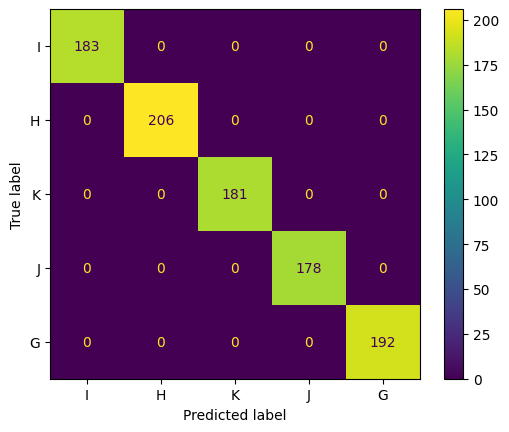

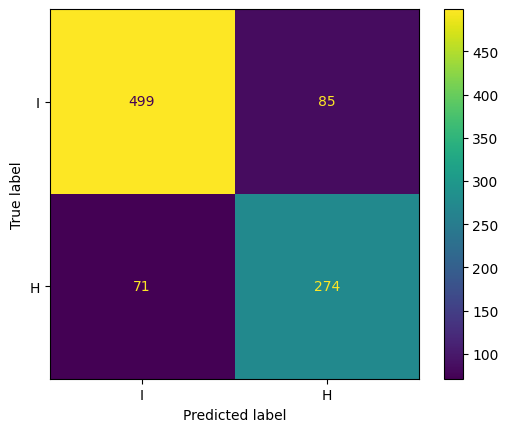

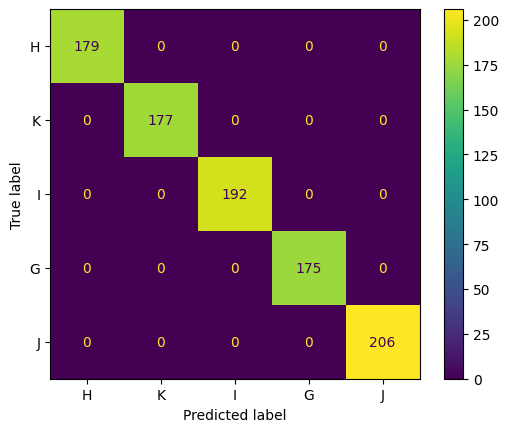

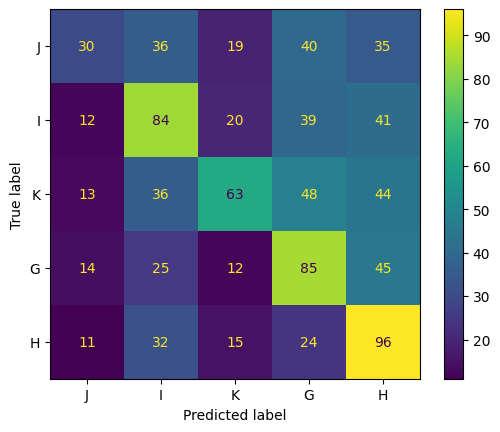

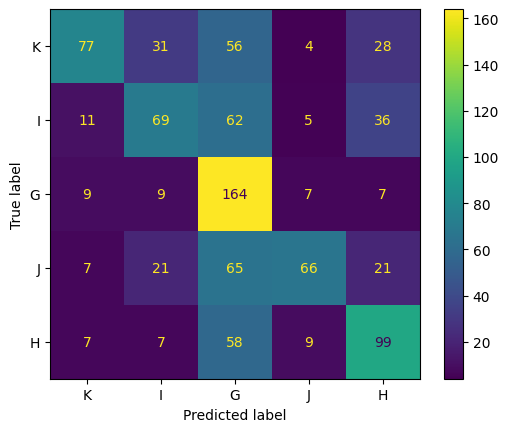

In [23]:
classifiers = []
cvs = []
conf_matrix = []
for i in range(1,6):


    y_label = f'C_{i}'
    raw = num_imputed_df.dropna(subset=y_label)
    X = raw.drop(columns=y_label)
    y = raw.loc[:, y_label]
    non_nan_categories = list(X.loc[:, X.columns.str.contains('C_')].dropna().apply(lambda x: x.unique()).to_numpy().T)
    
    
    display(non_nan_categories)
    
    onehot_no_nans_encoder = preproc.OneHotEncoder(
        categories = non_nan_categories, 
        handle_unknown='ignore', 
        sparse_output=False
    )
    transformer = make_column_transformer(
        (onehot_no_nans_encoder, categorical_columns),
        remainder = 'passthrough'
    )

    clf = KNeighborsClassifier()
    clf
    pipe = make_pipeline(transformer, clf)
    classifiers.append(pipe)
    cv = GridSearchCV(pipe, param_grid = {"kneighborsclassifier__n_neighbors": [i for i in range(1,11)]})
    cvs.append(cv)
    

    cv.fit(X, y)
    conf_mat = ConfusionMatrixDisplay.from_estimator(
        estimator = cv.best_estimator_,
        X = X,
        y = y,
        labels = y.unique()
    )
    conf_matrix.append(conf_mat)


In [9]:
y_label = f'C_{1}'
X = df.drop(columns=y_label)
y = 


In [6]:



imputed_data = num_imputed_df.copy()
for i in range(1,6):
    y_label = f'C_{i}'
    df = num_imputed_df.loc[num_imputed_df[y_label].isna()]
    X = df.drop(columns=y_label)
    preds = cvs[i-1].best_estimator_.predict(X)
    imputed_data.loc[num_imputed_df[y_label].isna(), y_label] = preds

imputed_data.to_csv('imputed_data.csv')

AttributeError: 'KNeighborsClassifier' object has no attribute 'score_samples'

### Correlation plot of imputed values 

/tmp/ipykernel_131202/720334086.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(imputed_data.corr(), vmin=-1, vmax=1, annot=False, cmap='BrBG')


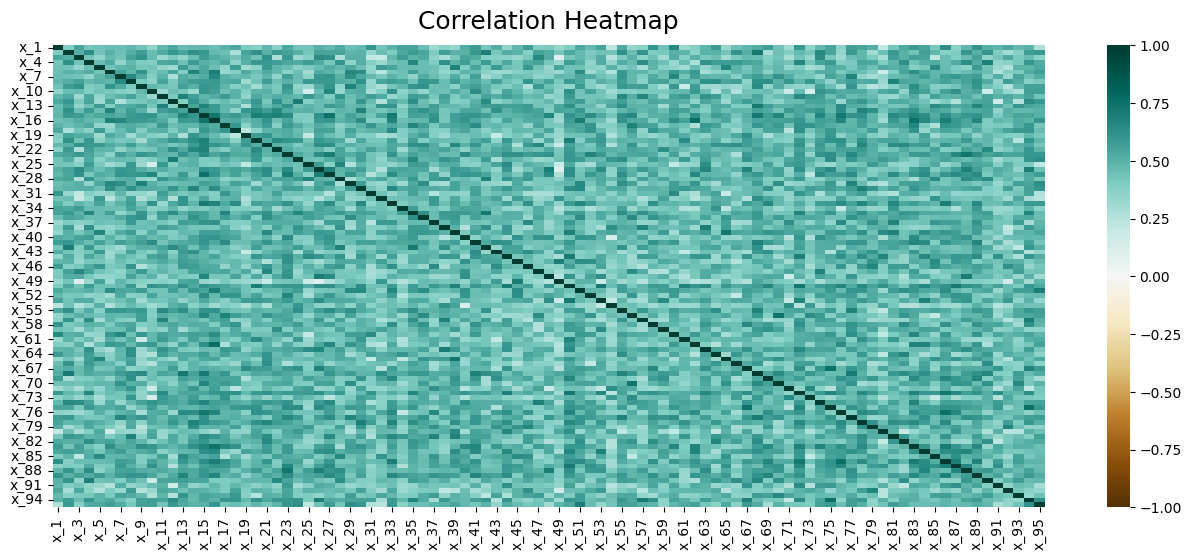

In [87]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(imputed_data.corr(), vmin=-1, vmax=1, annot=False, cmap='BrBG', )
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

# Modelling

In [93]:
linreg = linear.LinearRegression()
lasso = linear.LassoCV()
lasso_lars = linear.LassoLarsCV()
elastic = linear.ElasticNetCV()
# ridge = linear.RidgeCV()
pca = PCA()
onehot_encode = preproc.OneHotEncoder()
one_hot_transformer = ColumnTransformer([
    ('onehot_enc', onehot_encode, categorical_columns)
],remainder='passthrough')
pca_transformer = ColumnTransformer(
    [
    ('pca', pca, numerical_columns)
    ],
    remainder='passthrough'
)

ols = Pipeline([
    ('onehot', one_hot_transformer),
    ('linreg', linreg)
])

pca_ols = Pipeline([
    ('onehot', one_hot_transformer),
    ('pca', pca),
    ('linreg', linreg)
])




In [ ]:
outer_fold = StratifiedKFold(shuffle=True, random_state=184012184284)
inner_fold = StratifiedKFold(shuffle=True, random_state=184284184012)
for train, test in outer_fold.split(X, y)

